In [43]:
push!(LOAD_PATH,"../../../ExoJulia/")

include("../../hw2/Jake_Dave/utils.jl")
include("../../hw2/Jake_Dave/orbital_utils.jl")
include("../../hw2/Jake_Dave/rv.jl")
using ExoJulia
using PyPlot
using LsqFit
using Optim

In [2]:
function overlap_area(sep::Float64,k::Float64)
    # r: star - planet disk center separation per rstar
    # k: rp/rstar
    
    R = 1.0
    # No transit
    if sep >= k + R
        return 0.0
    end
    
    # Full transit
    if sep <= R - k
        return (k*k)/(R*R)
    end
        
    # Partial transit
    A = k*k*acos((sep*sep + k*k - R*R)/(2.0*sep*k)) + R*R*acos((sep*sep + R*R - k*k)/(2.0*sep*R))
    A -= 0.5*sqrt((-sep + k + R)*(sep + k - R)*(sep - k + R)*(sep + k + R))
    
    return A/(pi*R*R)
end

overlap_area (generic function with 1 method)

In [3]:
function relative_flux(sep::Float64,k::Float64)
    # Returns the relative flux observed for a planet - star system
    # in or out of transit
    # r: star - planet disk center separation
    # k: rp/rstar
    # Works as long as units are same or nothing
    
    return 1.0 - overlap_area(sep,k)
end

relative_flux (generic function with 1 method)

In [4]:
function center_separation(t::Float64,t0::Float64,period::Float64,d::Float64,inc::Float64,ecc::Float64,varpi::Float64)
# Computes separation of centers for star - planet system assuming star center at origin
# From Kreidberg 2015
    f = f_from_t(period, ecc, t, t0)
    
    if (pi <= (abs(f) + varpi)) && ((abs(f) + varpi <= 2.0*pi))
        return 1.0e99
    end
    
    return (d*((1.0-ecc*ecc)/(1.0 + ecc*cos(f)))*sqrt(1.0-(sin(varpi+f)^2.)*(sin(inc)^2.)))
end

center_separation (generic function with 1 method)

In [5]:
function impact_separation(b::Float64,t::Float64,v::Float64)
    return sqrt(b^2+(v.*(t)).^2)
end

impact_separation (generic function with 1 method)

In [6]:
function transit_prob(Rp::Float64,Rs::Float64,ecc::Float64,semi::Float64)
    return (Rp + Rs)/(semi*(1.0 + ecc*ecc))
end

transit_prob (generic function with 1 method)

In [7]:
function transit_duration()
    
end

transit_duration (generic function with 1 method)

In [8]:
overlap_area(0.0,0.05,0.5)

LoadError: LoadError: MethodError: `overlap_area` has no method matching overlap_area(::Float64, ::Float64, ::Float64)
Closest candidates are:
  overlap_area(::Float64, ::Float64)
while loading In[8], in expression starting on line 1

In [9]:
relative_flux(0.0,0.05,0.5)

LoadError: LoadError: MethodError: `relative_flux` has no method matching relative_flux(::Float64, ::Float64, ::Float64)
Closest candidates are:
  relative_flux(::Float64, ::Float64)
while loading In[9], in expression starting on line 1

# Read in data, test

In [10]:
data = readdlm("mystery_planet2.txt");
time = data[:,1];
flux = data[:,2];
err = data[:,3];

In [46]:
data_fold = copy(data)
data_fold[:,1] = mod(data[:,1] - data[1,1], 12.1429)
data_fold = fastsortrows(data_fold,[1]);

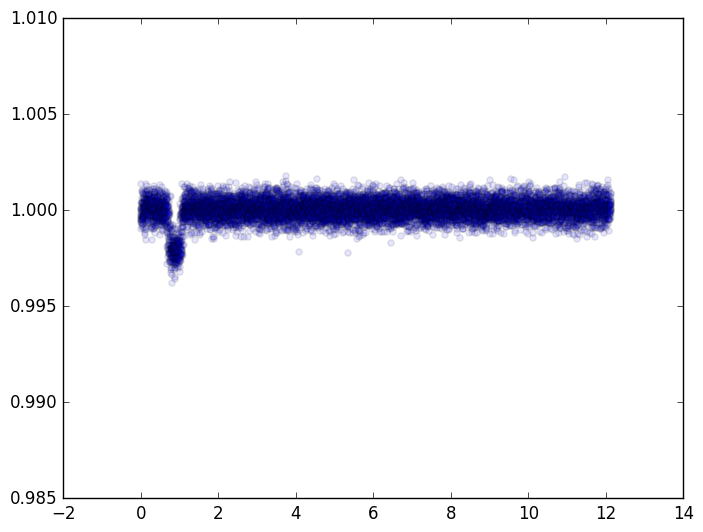

PyObject <matplotlib.collections.PathCollection object at 0x321b0efd0>

In [47]:
scatter(data_fold[:,1],data_fold[:,2]/mean(data_fold[:,2]),alpha=0.1)

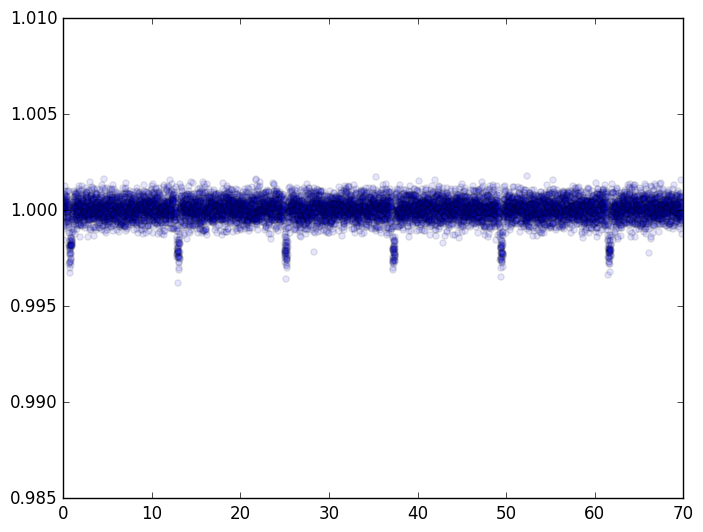

(0.0,69.992996)

In [13]:
scatter(data[:,1],data[:,2]/mean(data[:,2]),alpha=0.1)
xlim(data[1,1],data[end,1])

In [14]:
function period_to_semi(P::Float64,Ms::Float64,Mp::Float64)
    Pyear = P/365.0 # takes in period in days
    return (Pyear*Pyear*(Ms+Mp))^(1./3.)
end

period_to_semi (generic function with 1 method)

In [75]:
period = 5.0 #days
b = 0.0 # impact parameter
Ms = 1.0 # Msol
Mp = 3.003467e-6*20 # mass of earth in solar masses 
Rs = 1.0 # solar radii
Rp = 0.009*5.0 # Earth radius in solar radii
ecc = 0.5
varpi = 0.0 + pi/2.0 # rads
semi = period_to_semi(period,Ms,Mp)/0.004649 
inc = 98.0*(pi/180.0) # rads
fi = 3.*pi/2 - varpi
velocity = 2.0*pi*semi/period
tp = period * sqrt(1. - ecc * ecc) / (2. * pi) * (ecc * sin(fi) / (1. + ecc * cos(fi)) - 2. / sqrt(1. - ecc * ecc) * atan2(sqrt(1. - ecc * ecc) * tan(fi/2.), 1. + ecc));

In [76]:
time_hires = collect(linspace(0,15,10000))
rel_flux = zeros(length(time_hires))
distance = zeros(length(time_hires))
for i=1:length(time_hires)
    distance[i] = center_separation(time_hires[i],time_hires[1]+tp,period,semi,inc,ecc,varpi)/Rs # a/Rstar
    rel_flux[i] = relative_flux(distance[i],Rp)
end

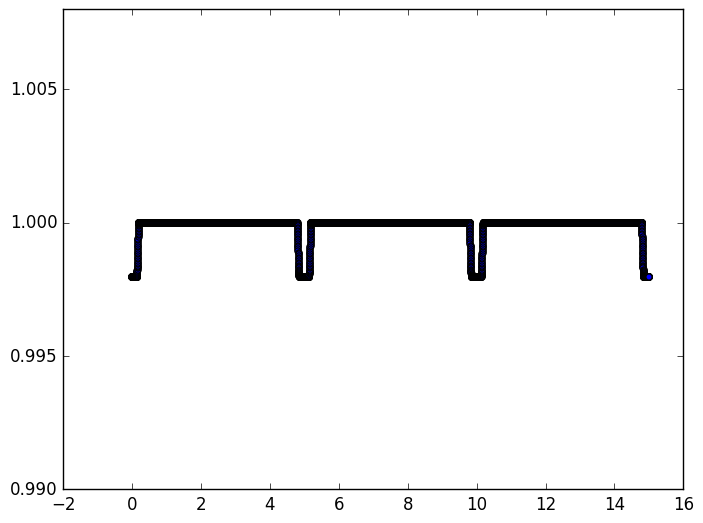

PyObject <matplotlib.collections.PathCollection object at 0x3233c1990>

In [77]:
scatter(time_hires,rel_flux)
#xlim(1.1,1.5)
#ylim(0.995,1.005)

In [18]:
data = readdlm("mystery_planet2.txt");
time = data[:,1];
flux = data[:,2];
err = data[:,3];

In [19]:
periods = linspace(5.0,15.0,100)
periods = collect(periods);

In [377]:
function transit_loglike(params)
    # params = [rp/rs, d, ecc, varpi, inc, period] where d = a/rstar
    
    # Hard bounds
    if params[1] < 0.0 || params[1] >= 1.0
        return Inf
    end
    if params[2] < 0.0
        return Inf
    end
    if params[3] < 0.0 || params[3] >= 1.0
        return Inf
    end
    if(params[4] < 0.0) || (params[4] > 2.0*pi)
        return Inf
    end
    if (params[5] > (100.0*pi/180.0)) || (params[5] < (80.0*pi/180.0))
        return Inf
    end
    if(params[6] <= 0.0)
        return Inf
    end
    
    # Note: - because optim looks for MINIMUM!
    model = transit_model(time,params);
    
    return -loglike(flux, model, err);
end

transit_loglike (generic function with 1 method)

In [378]:
function transit_model(time::Array{Float64,1},params::Vector)
    # params = [rp/rs, d, ecc, varpi, inc, period] where d = a/rstar
    k = params[1]
    d = params[2]
    ecc = params[3]
    varpi = params[4] + pi/2.0 # rads
    inc = params[5]
    per = params[6]
    
    tp = per*sqrt(1.-ecc*ecc)/(2.*pi)*(ecc*sin(fi)/(1.+ecc*cos(fi))-2./sqrt(1.-ecc*ecc)*atan2(sqrt(1.-ecc*ecc)*tan(fi/2.),1.+ecc))
    
    data_fold = [time flux err]
    data_fold[:,1] = mod(time[1] - time[1], per)
    data_fold = fastsortrows(data_fold,[1]);
    
    rel_flux = zeros(length(time))
    distance = 0.0
    for i=1:length(time)
        distance = center_separation(time[i],time[1]+tp,per,d,inc,ecc,varpi)
        rel_flux[i] = relative_flux(distance,k)
    end
    
    return rel_flux
end

transit_model (generic function with 1 method)

In [405]:
# params = [rp/rs, d, ecc, varpi, inc, period] where d = a/rstar
params = [0.01, 20.0, 0.1, 0.15, 92.*pi/180., 12.0]

6-element Array{Float64,1}:
  0.01  
 20.0   
  0.1   
  0.15  
  1.6057
 12.0   

In [407]:
optimum = optimize(transit_loglike, params, method=:"cg")

LoadError: LoadError: TypeError: optimize: in typeassert, expected Symbol, got ASCIIString
while loading In[407], in expression starting on line 1

In [404]:
# params = [rp/rs, d, ecc, varpi, inc, period] where d = a/rstar
optimum.minimum

6-element Array{Float64,1}:
  0.152857
 20.1429  
  0.242857
  0.292857
  1.74856 
 12.1429  

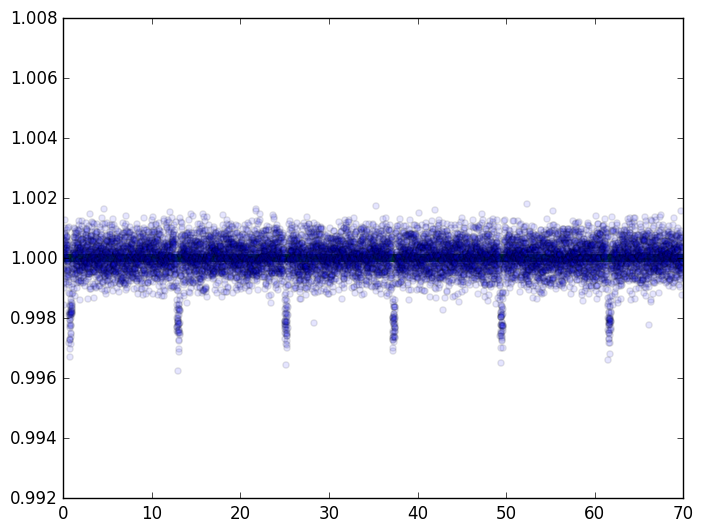

(0.0,69.992996)

In [393]:
scatter(time,transit_model(time,optimum.minimum),color="green")

scatter(data[:,1],data[:,2]/mean(data[:,2]),alpha=0.1)
xlim(data[1,1],data[end,1])

In [394]:
data_fold = copy(data)
data_fold[:,1] = mod(data[:,1] - data[1,1], 12.1429)
data_fold = fastsortrows(data_fold,[1]);

data_fit = [time transit_model(time,optimum.minimum)]
data_fit[:,1] = mod(data[:,1] - data[1,1], 12.1429)
data_fit = fastsortrows(data_fit,[1]);

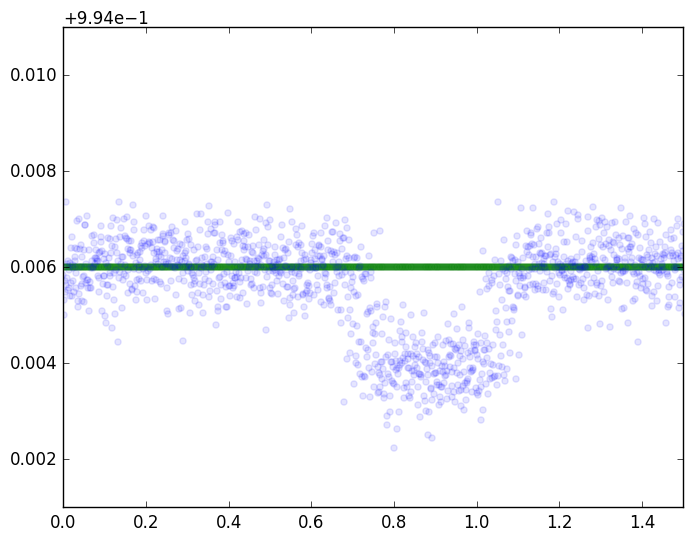

(0,1.5)

In [395]:
scatter(data_fit[:,1],data_fit[:,2],color="green",alpha=0.1)
scatter(data_fold[:,1],data_fold[:,2]/mean(data_fold[:,2]),color="blue",alpha=0.1)
ylim(0.995,1.005)
xlim(0,1.5)